<h1>An Analysis of COVID19 Recovery Durations<h1>

## 1. The Code (in a Python class)

Run this code [on colab](https://colab.research.google.com/github/sanjaydasgupta/covid19-recovery-duration-analysis/blob/master/covid19-recovery-duration-analysis.ipynb).

In [17]:
import pandas as pd
from matplotlib.colors import ListedColormap
import numpy as np
from functools import reduce
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error
from random import seed, choices
from collections import defaultdict


class CovidData:

  def __init__(self):
    states_url = 'https://api.covid19india.org/csv/latest/state_wise.csv'
    state_df = pd.read_csv(states_url)
    self.state_name_map = {code: name for name, code in state_df[['State', 'State_code']].values}
    csv_url = 'https://api.covid19india.org/csv/latest/state_wise_daily.csv'
    raw_df = pd.read_csv(csv_url)
    raw_df['Date'] = pd.to_datetime(raw_df['Date'])
    self.raw_df = raw_df
    self.date_min = raw_df['Date'].min()
    self.date_max = raw_df['Date'].max()

  def __repr__(self):
    return '%s(%s:%s)' % (self.__class__.__name__, str(self.dateMin).split()[0], str(self.dateMax).split()[0])
  
  def organizeStateData(self, state_code, date_start=None, date_end=None):
    self.date_start = date_start if date_start else self.date_min
    self.date_end = date_end if date_end else self.date_max
    row_count = (pd.to_datetime(self.date_end) - pd.to_datetime(self.date_start)).days + 1
    self.state_code = state_code
    dfs = self.raw_df[['Date', 'Status', state_code]].groupby(['Date', 'Status']).sum().unstack()
    dfs.columns = [p[1] for p in dfs.columns]
    dfs['ConfPrefix'] = dfs['Confirmed'].shift(row_count).fillna(0)
    self.state_df = dfs.query("Date >= '%s' and Date <= '%s'" % (self.date_start, self.date_end)).copy().astype(int)

  def getXy(self):
    X = self.state_df[['ConfPrefix', 'Confirmed', 'Deceased']].values
    y = self.state_df['Recovered'].values
    return X, y

  def predict_normal(self, X, y):
    self.rng = np.random.default_rng()
    infections = X[:, :2].transpose().ravel()
    df = pd.DataFrame(enumerate(infections), columns=['idx', 'infections'])

    def normal_ttr_values(infections):
      if infections > 0:
        normal_values = self.rng.standard_normal(int(infections))
        scaled_values = np.absolute(normal_values * self.sigma) + self.mean
        integer_values = np.apply_along_axis(int, 0, [scaled_values])
        return integer_values
      else:
        return []

    # TTR - Time to Recovery (from time of infection)
    df['ttr'] = df['infections'].map(normal_ttr_values)

    # TOR - Time of Recovery (offset from origin of dataset)
    df['tor'] = df.apply(lambda row: [row['idx'] + ttr for ttr in row['ttr']], axis=1)

    # TOR2 - Valid TOR values (falling within time range of dataset)
    y_len, x_len = len(X), len(infections)
    offset_start, offset_end = x_len - y_len, x_len
    df['tor2'] = df['tor'].map(lambda offsets: [ofs for ofs in offsets if ofs >= offset_start and ofs < offset_end])

    tor_counts = defaultdict(int)
    for tor2 in df['tor2']:
      for e in tor2:
        tor_counts[e] += 1
    tor_series = pd.Series(tor_counts).reindex(range(offset_start, offset_end)).fillna(0)
    deaths = X[:, 2]
    
    prediction = np.where(deaths >= tor_series, 0, tor_series - deaths)
    score = mean_squared_error(y, prediction)
    return prediction, score

  def predict(self, state_code, mean, sigma, date_start='2020-05-15', date_end='2020-08-31'):
    self.mean = mean
    self.sigma = sigma
    self.organizeStateData(state_code, date_start, date_end)
    X, y = self.getXy()
    prediction, score = self.predict_normal(X, y)
    self.state_df['Prediction'] = prediction
    self.score = mean_squared_error(y, prediction)

  def predict_uniform(self, state_code, mean, spread, date_start='2020-05-15', date_end='2020-08-31'):
    self.mean = mean
    self.spread = spread
    self.organizeStateData(state_code, date_start, date_end)
    X, y = self.getXy()
    infections0 = X[:, 0]
    infections1 = X[:, 1]
    infections = np.concatenate((infections0, infections1))
    df = pd.DataFrame(enumerate(infections), columns=['idx', 'infections'])
    # TTR - Time to Recovery (from time of infection)
    ttr_min = self.mean - self.spread
    ttr_max = self.mean + self.spread + 1
    ttr_choices = range(ttr_min, ttr_max)

    #df['ttr'] = df['infections'].map(lambda infections: choices(ttr_choices, k=int(infections)))
    df['ttr'] = df['infections'].map(lambda infections: choices(ttr_choices, k=infections))
    # TOR - Time of Recovery (offset from origin of dataset)
    df['tor'] = df.apply(lambda row: [row['idx'] + delta for delta in row['ttr']], axis=1)
    # TOR2 - Valid TOR values (falling within time range of dataset)

    size = len(X)
    df['tor2'] = df['tor'].map(lambda offsets: [ofs for ofs in offsets if ofs >= size and ofs <= size * 2])
    #display(df.applymap(lambda e: type(e)))

    def extend2(a, b):
      a.extend(b)
      return a
    #all_tor_values = reduce(lambda a, b: extend2(a, b), df['tor2'])
    all_tor_values = reduce(extend2, df['tor2'])

    tor_counts = defaultdict(int)
    for tor in all_tor_values:
      tor_counts[tor] += 1
    tor_series = pd.Series(tor_counts).reindex(range(size, 2* size)).fillna(0)
    deaths = X[:, 2]
    #return (tor_series - deaths).map(lambda e: max(e, 0)).values
    prediction = np.where(deaths >= tor_series, 0, tor_series - deaths)
    self.state_df['Prediction'] = prediction
    self.score = mean_squared_error(y, prediction)

  def plot(self, ax):
    if 'Prediction' in self.state_df.columns.values:
      self.state_df[['Confirmed', 'Deceased', 'Recovered', 'Prediction']].plot(ax=ax, grid=True, 
          colormap=ListedColormap(['blue', 'coral', 'green', 'olive']), sharex=True)
      ax.set_title('%s (mean: %d, sigma: %d)\nscore: %5.2f' % 
          (self.state_name_map[self.state_code], self.mean, self.sigma, self.score))
    else:
      self.state_df[['Confirmed', 'Deceased', 'Recovered']].plot(ax=ax, grid=True, 
          colormap=ListedColormap(['blue', 'coral', 'green']), sharex=True)
      ax.set_title(self.state_name_map[self.state_code])

### 1.1 Some Quick Tests

In [ ]:
cd = CovidData()
cd.organizeStateData('WB', '2020-08-01', '2020-08-31')
display(cd.state_df)
cd.getXy()

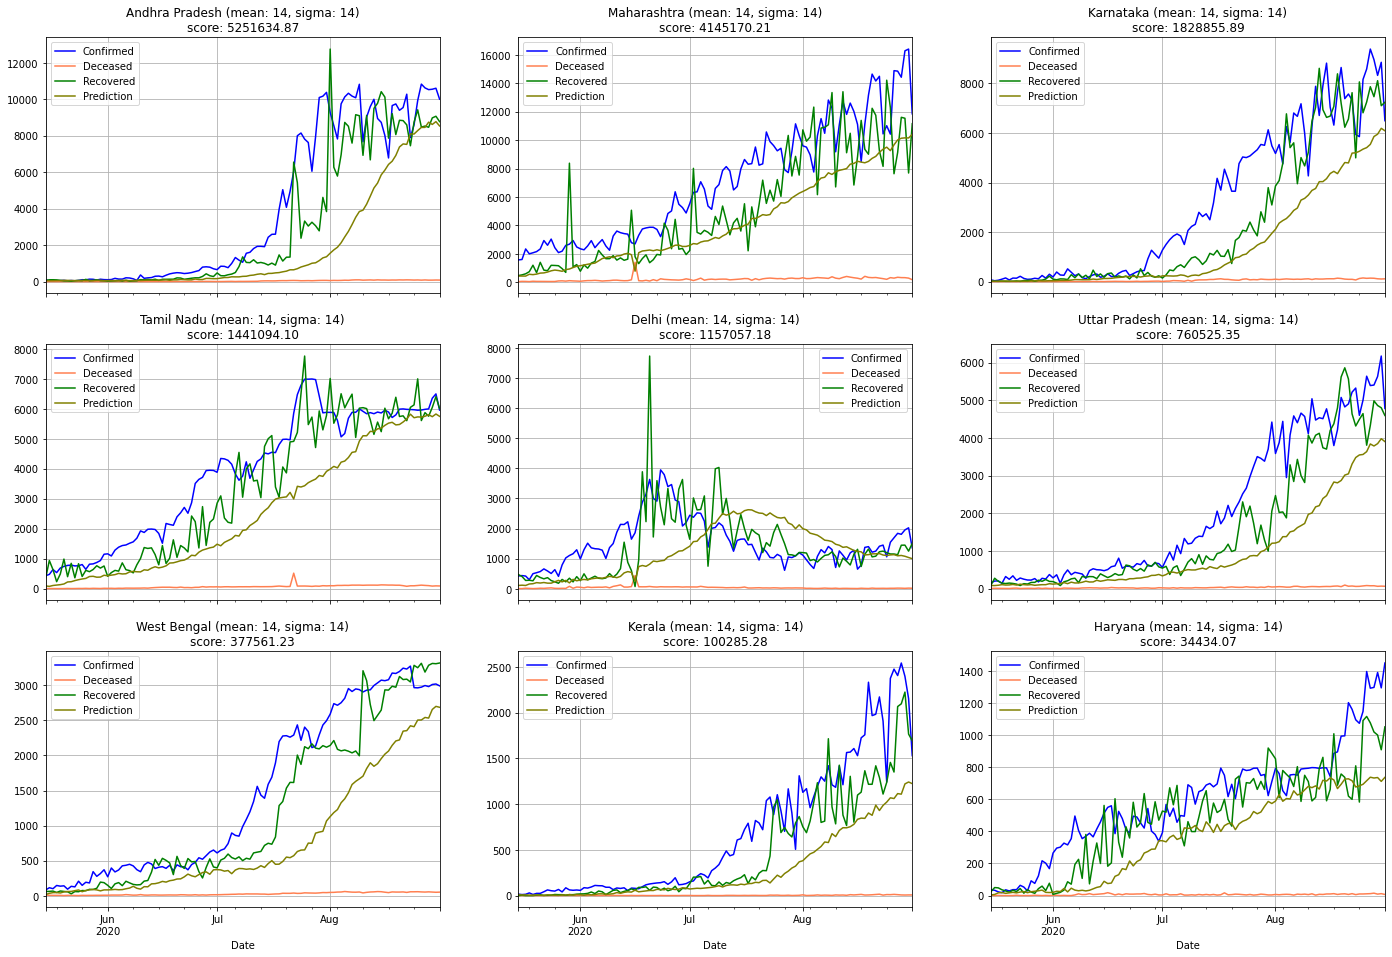

In [18]:
import matplotlib.pyplot as plt

states = ['AP', 'MH', 'KA', 'TN', 'DL', 'UP', 'WB', 'KL', 'HR']

fig, axes = plt.subplots(3, 3, figsize=(24, 16))
stax = zip(states, axes.ravel())
for st, ax in stax:
  sd = CovidData()
  sd.predict(st, 14, 14)
  sd.plot(ax)

## 2. Some Applications

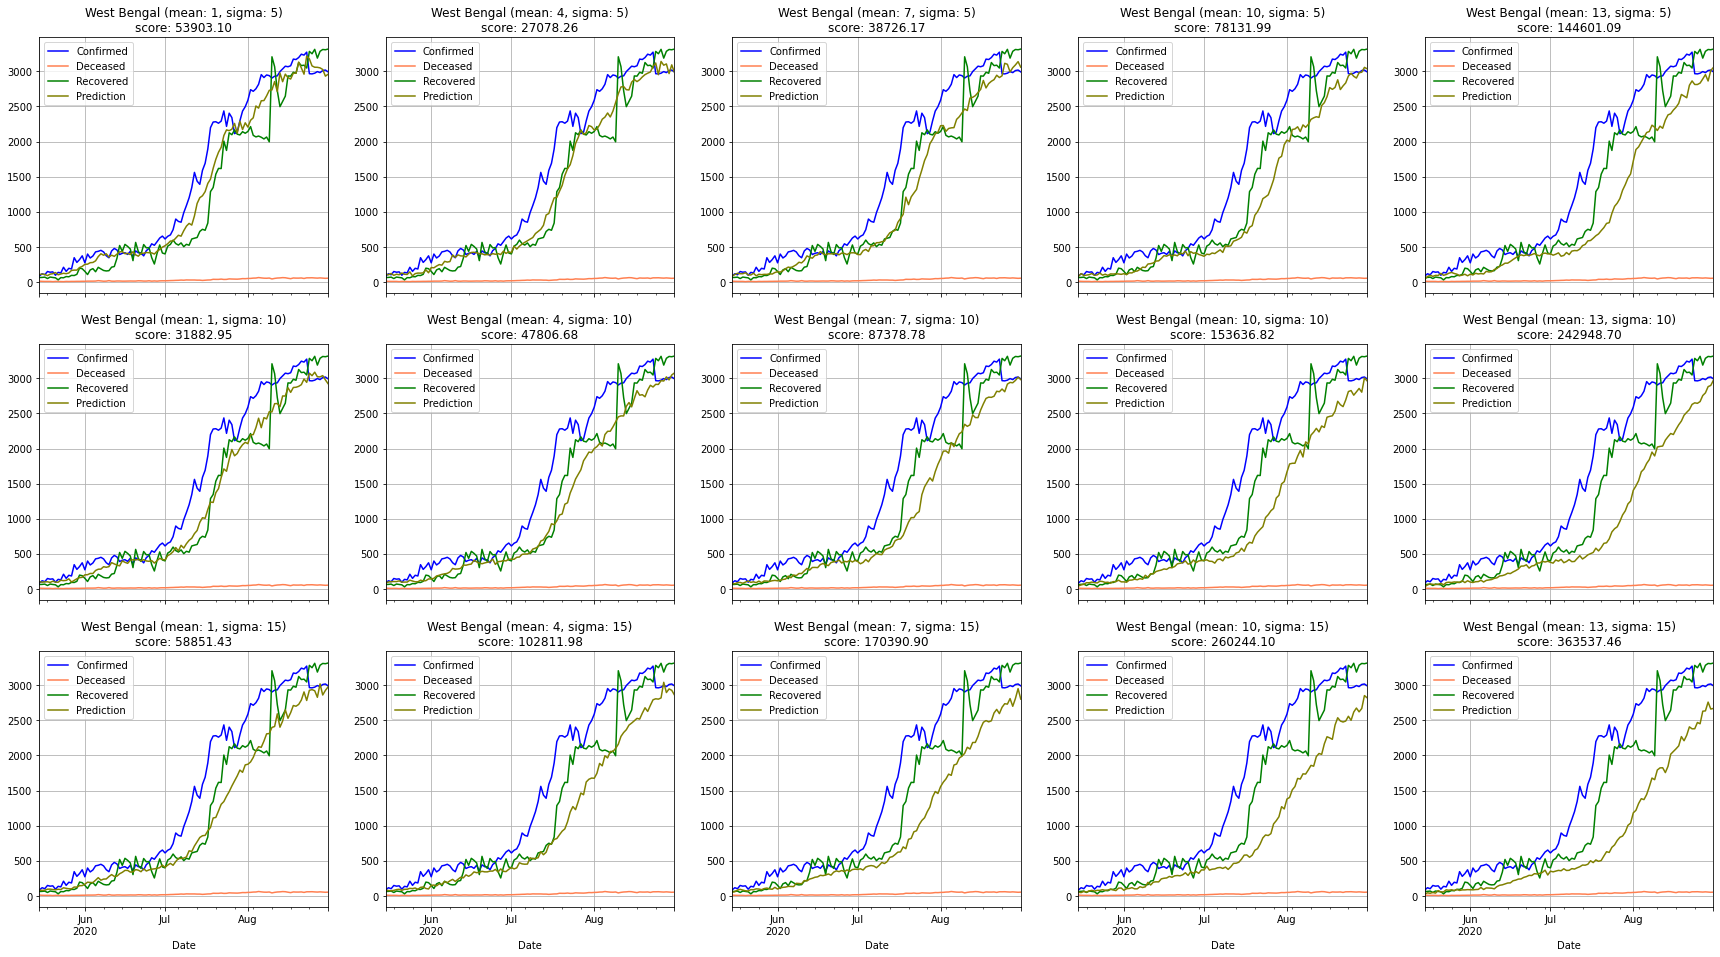

In [19]:
import matplotlib.pyplot as plt

states = ['AP', 'MH', 'KA', 'TN', 'DL', 'UP', 'WB', 'KL', 'HR']

sd = CovidData()
fig, axes = plt.subplots(3, 5, figsize=(30, 16))
means, spreads = [1, 4, 7, 10, 13], [5, 10, 15]
for sx in range(3):
  for mx in range(5):
    mean, spread = means[mx], spreads[sx]
    sd.predict('WB', mean, spread)
    sd.plot(axes[sx, mx])

## 3. Some Predictions

### 3.1 ???

## 4. Some Questions